In [7]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy import spatial


In [8]:
def plot_cells(axes, x_array, y_array, radius=0.5, **kwargs):
    for x, y in zip(x_array, y_array):
        circle = plt.Circle((x,y), radius=radius, alpha=0.25, **kwargs)
        axes.add_patch(circle)
        plt.axis('scaled')
    return True

def plot_centers(axes, x_array, y_array, **kwargs):
    for x, y in zip(x_array, y_array):
        circle = plt.Circle((x,y), radius=1, alpha=1, **kwargs)
        axes.add_patch(circle)
        plt.axis('scaled')
    return True

In [103]:
def intersection_area(d, R, r):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """

    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )


def get_forces(pos):
    import collections
    pdist = spatial.distance.pdist
    sq = spatial.distance.squareform
    distances = sq(pdist(pos))
    diameter = 2.0*radius
    sum_of_forces = 0.
    for row in distances:
        overlapping_cells = np.where((row > 0) & (row < diameter)) # if relaxed, centers must be 2 radii distance 
        distances_to_overlapping_cells = row[overlapping_cells]

        num_overlapping_cells = np.array(overlapping_cells).size

        # Hooke's law of spring
        ## proportional to overlap 
        kappa = 0.1  # spring constant
        forces_exclusion_magnitude = []
        for d in distances_to_overlapping_cells:
            compression = d - diameter
            force_magnitude = kappa * compression
            forces_exclusion_magnitude.append(force_magnitude)

        forces_adhesion_magnitude = []            
        for d in distances_to_overlapping_cells:
            overlap_area = intersection_area(d,radius, radius)    
            force_magnitude = -0.01 * (overlap_area-10.0)
            forces_adhesion_magnitude.append(force_magnitude)
        
        forces_magnitude = forces_adhesion_magnitude + forces_exclusion_magnitude
        
        my_position = pos[np.where(row == 0)][0]
        positions_of_overlapping_cells = pos[overlapping_cells]

        forces_direction = []
        for p in positions_of_overlapping_cells:
            diff = p - my_position
            force_direction = diff
            forces_direction.append(force_direction)
        
        
        F = [0,0]
        for d,m in zip(forces_direction, forces_magnitude):
            F += d * m
        
        # random motion
        random_motion = 0.0
        random_magnitude = np.random.random()*random_motion
        forces_random_magnitude = random_magnitude
        random_direction = np.array([np.random.random()-0.5, np.random.random()-0.5])
        forces_random_direction = random_direction 
        F += forces_random_direction * forces_random_magnitude
    
        try:
            forces.append(F)
        except:
            forces = [F]
        
        sum_of_forces += np.sum(forces_magnitude)
    return forces, sum_of_forces


In [104]:
def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    an = np.take(a,p,axis=0)
    bn = np.take(b,p,axis=0)
    return an, bn

def step(pos, dt=0.01, mu=10.0):

    # compute the forces working on each cell
    forces, sum_of_forces = get_forces(pos)
    #print forces
    #get_forces_matrix(pos)

    
    # shuffle the rows to ensure cells are randomly updated
    pos, forces = unison_shuffled_copies(pos, forces)
    
    for p, f in zip(pos, forces):
        #print 'before: ', p, f
        
        if np.sum(f) != 0:
            newp = p + dt/mu * f
        else:
            newp = p
        #print 'after: ', newp
        try:
            newpos.append(newp)
        except:
            newpos = [newp]
    
    if np.array_equal(pos, newpos):
        changed = False
    else:
        changed = True
    

    return np.array(newpos), forces, sum_of_forces, changed


In [105]:
from timeit import default_timer as timer

In [106]:
def run_simulation(numcells, radius, size, end=1000, plot=True):
    # generate random initial positions
    xs, ys = np.random.random_sample(numcells)*size[0], np.random.random_sample(numcells)*size[1]
    positions = np.transpose(np.array([xs,ys]))

    if plot:
        from IPython import display
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        plot_centers(ax, positions[:,0], positions[:,1])
        plot_cells(ax, positions[:,0], positions[:,1], radius=radius)
        ax.set_xlim(-size[0], 2.0*size[0])
        ax.set_ylim(-size[1], 2.0*size[1])

    im_count = 0
    start = timer()
    for t in range(0,end):

        positions, forces, sum_of_forces, changed = step(positions, dt=0.25)
        positions = np.array(positions)

        if plot and t % 25 == 0:
            ax.clear()
            plot_centers(ax, positions[:,0], positions[:,1])
            plot_cells(ax, positions[:,0], positions[:,1], radius=radius)
            ax.set_xlim(-size[0], 2.0*size[0])
            ax.set_ylim(-size[1], 2.0*size[1])
            ax.set_title('t = {: 6d}, f = {: 8.2f}'.format(t, sum_of_forces))
            arrow_size = 1
            for p,f in zip(positions, forces):
                ax.arrow(x=p[0], y=p[1], dx=f[0]*arrow_size, dy=f[1]*arrow_size, head_width=0.01+1.0*int(np.sum(np.abs(f))>0))

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.savefig('frame_{:05d}'.format(im_count))
            im_count += 1

        if not changed: #or abs(sum_of_forces) < 1.0:
            print "No change"
            break
    end = timer()
    return end-start

In [107]:
def get_forces_matrix(pos):
    pdist = spatial.distance.pdist
    sq = spatial.distance.squareform
    distances = sq(pdist(pos))

    # mask the distance matrix to only reveal distance smaller than diameter
    diameter = 2.0*radius
    mask=(distances==0) | (distances>diameter)
    masked_dist = np.ma.masked_array(distances, mask=mask)
    
    print 'pos:  ',pos
    pos_x = pos[:,0]
    pos_y = pos[:,1]
    displacements_x = sq(pdist(pos, lambda u,v: u[0]-v[0]))
    displacements_y = sq(pdist(pos, lambda u,v: u[1]-v[1]))
    
    print 'masked dist:'
    print masked_dist
    
    kappa=0.1 # spring constant
    def force_repulsion(x):
        return kappa * (x - diameter)    
    force_repulsion_v = np.vectorize(force_repulsion)
    forces_repulsion_magnitudes = force_repulsion_v(masked_dist)
    
    #def force_adhesion(x):
    #    return 0.05 * (x - (diameter-2.0))
    #force_adhesion_v = np.vectorize(force_adhesion)
    #forces_adhesion_magnitudes = force_adhesion_v(masked_dist)

    # include other forces in the same way ...
    
    # finally, add all forces
    forces_magnitudes = forces_repulsion_magnitudes#+ forces_adhesion_magnitudes
    
    print 'forces magn:'
    print forces_magnitudes
    print 'displacements:'
    print displacements_x
    
    forces_x = np.multiply(displacements_x, forces_magnitudes)
    forces_y = np.multiply(displacements_y, forces_magnitudes)
    
    print 'forces x'
    print forces_x
    print 'forces y'
    print forces_y
    # get the positions of the cells that belong to these distances
    #ind_masked = np.transpose(np.nonzero(mask==False))
    #ind_masked = ind_masked[:len(ind_masked)/2] # only get the first half (rest is repetition)
    #print ind_masked
    #positions_forces = pos[ind_masked][0]
    forces = np.array( [forces_x[ind_masked[:,0]].compressed(), forces_y[ind_masked[:,1]].compressed() ])

    # compute x and y displacements between cells
    #displacements_x = sq(pdist(pos, lambda u, v: (u[0]-v[0])))
    #displacements_y = sq(pdist(pos, lambda u, v: (u[1]-v[1])))
    
    #for p in pos:
        
    
    return forces, np.sum(forces_magnitudes)
    #print masked_pos

Numcells:   100 Time: 43.92


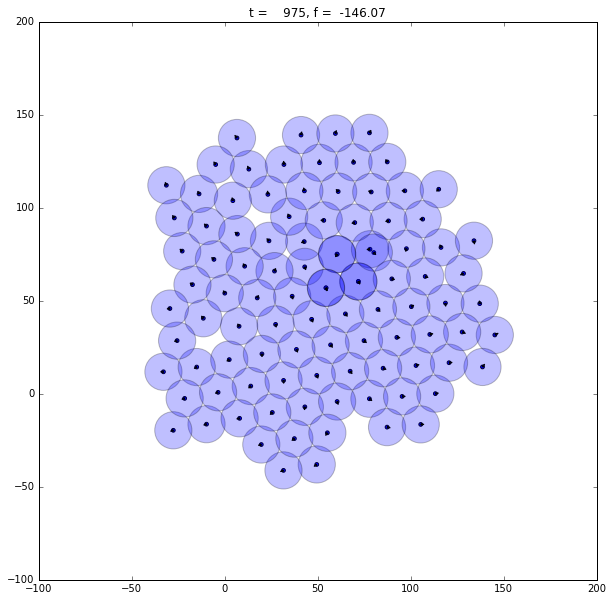

In [108]:
numcells = 100
radius = 10
size = (100,100)
lambda_a = 1.0
lambda_e = 1.0
elapsed = run_simulation(numcells, radius, size, end=1000, plot=True)
print 'Numcells: {:5d} Time: {:5.2f}'.format(numcells, elapsed) 


## performance analysis

Numcells:     1 Time:  0.14
Numcells:    26 Time:  1.26
Numcells:    51 Time:  2.35
Numcells:    76 Time:  3.63
Numcells:   101 Time:  4.94
Numcells:   126 Time:  6.45
Numcells:   151 Time:  8.06
Numcells:   176 Time:  9.83

In [43]:
result = dict()
for n in np.arange(start=1, stop=200, step=25):

    numcells = n
    radius = 10
    size = (100,100)

    elapsed = run_simulation(numcells, radius, size)
    print 'Numcells: {:5d} Time: {:5.2f}'.format(numcells, elapsed) 

    result[n] = elapsed


Numcells:     1 Time:  0.14
Numcells:    26 Time:  1.26
Numcells:    51 Time:  2.35
Numcells:    76 Time:  3.63
Numcells:   101 Time:  4.94
Numcells:   126 Time:  6.45
Numcells:   151 Time:  8.06
Numcells:   176 Time:  9.83


<Container object of 8 artists>

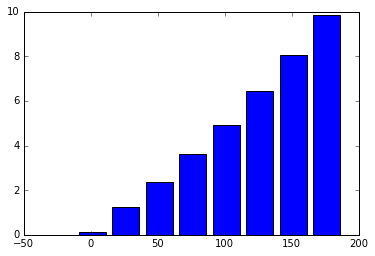

In [44]:
plt.bar(result.keys(), result.values(), align='center', width=20)
